In [1]:
import torch
print(torch.cuda.is_available()) # Ha de ser True

True


# Overview

Can a computer "learn" to classify artists by their paintings? 

ResNet50 is a good model for classifying ImageNet data. How about a set of 38 artists?

We use transfer learning to re-train a ResNet50 model to identify one of 38 artists who have more than ***200*** paintings in the dataset. 

This notebook is part of a project for CSC 480 taught by [Dr. Franz J. Kurfess](http://users.csc.calpoly.edu/~fkurfess/) at Cal Poly

A web application is [in development](https://github.com/SomethingAboutImages/WebImageClassifier) to make use of the model that this notebook outputs. 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# %matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info

import gc # garbage collection

In [3]:
MY_SEED = 42 # 480 could work too
seed(MY_SEED)
np.random.seed(MY_SEED)
tensorflow.random.set_seed(MY_SEED)

print(sys_info())
# get module information
# %pip freeze > frozen-requirements.txt
# append system information to file
# with open("frozen-requirements.txt", "a") as file:
#     file.write(sys_info())

{'commit_hash': '37242ba43',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython',
 'ipython_version': '8.12.0',
 'os_name': 'posix',
 'platform': 'Linux-5.15.0-1064-azure-x86_64-with-glibc2.17',
 'sys_executable': '/anaconda/envs/py38_default/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.8.16 (default, Mar  2 2023, 03:21:46) \n[GCC 11.2.0]'}


In [4]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3948908814257295116
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14682882048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14281850004130055162
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [5]:
# https://stackoverflow.com/questions/25705773/image-cropping-tool-python
# because painting images are hella big
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

## Directories

In [6]:
# marta
# DATA_DIR = r"C:\Users\jesus\Desktop\Projecte"
# TRAIN_1_DIR = r"C:\Users\jesus\Desktop\Projecte\train_10_artists\train_10_artists"
#TRAIN_2_DIR = r"C:\Users\jesus\Desktop\Projecte\imatges\train_9\train_9"
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = r"C:\Users\jesus\Desktop\Projecte\test"

# marta azure
# DATA_DIR = '/home/xnmaster/Pictures'
# TRAIN_1_DIR = '/home/xnmaster/Pictures/train_10_artists/train_10_artists'
# TEST_DIR = r"/Users/jesus/Desktop/Projecte/test" 
# TEST_DIR = "/home/xnmaster/Pictures/test"

# mercè 
# DATA_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input" 
# TRAIN_1_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\train_10_selected_artists\train_10_selected_artists"
# TEST_DIR = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\input\test\test"
TRAIN_1_DIR = "/home/xnmaster/Project/input/train_10_selected_artists"
TEST_DIR = "/home/xnmaster/Project/input/test"
TRAIN_DIRS = [TRAIN_1_DIR]

In [7]:
# Get the list of files in the folder
files_in_folder = os.listdir(TRAIN_1_DIR)

# Count the number of files in the folder
num_files_in_train = len(files_in_folder)

print("Number of files in the folder TRAIN_1_DIR:", num_files_in_train)


files_in_folder = os.listdir(TEST_DIR)

# Count the number of files in the folder
num_files_in_test = len(files_in_folder)

print("Number of files in the folder TEST_DIR:", num_files_in_test)


Number of files in the folder TRAIN_1_DIR: 3672
Number of files in the folder TEST_DIR: 7025


In [8]:
# df = pd.read_csv('/home/xnmaster/Pictures/all_data_info.csv') # r'\train_info\train_info.csv'
df = pd.read_csv('/home/xnmaster/Project/input/all_data_info/all_data_info.csv')
print("df.shape", df.shape)

df.shape (103250, 12)


In [9]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


Keep the works of artists who have a representation above x

In [9]:
# Count occurrences of each artist
# artist_counts = df['artist'].value_counts()

## Artists

In [10]:
train_df = df[df["in_train"] == True]
test_df = df[df['in_train'] == False]
train_df = df[['artist', 'new_filename']]
test_df = test_df[['artist', 'new_filename']]

print("test_df.shape", test_df.shape)
print("train_df.shape", train_df.shape)

test_df.shape (23817, 2)
train_df.shape (103250, 2)


In [11]:
artists = {'Camille Pissarro': 393,
 'Vincent van Gogh': 392,
 'Theophile Steinlen': 389,
 'Pierre-Auguste Renoir': 388,
 'Boris Kustodiev': 388,
 'Pyotr Konchalovsky': 388,
 'Gustave Dore': 387,
 'Edgar Degas': 387,
 'Camille Corot': 387,
 'Eugene Boudin': 387
}

In [12]:
training_set_artists = list(artists.keys())
training_set_artists

['Camille Pissarro',
 'Vincent van Gogh',
 'Theophile Steinlen',
 'Pierre-Auguste Renoir',
 'Boris Kustodiev',
 'Pyotr Konchalovsky',
 'Gustave Dore',
 'Edgar Degas',
 'Camille Corot',
 'Eugene Boudin']

In [13]:
t_df = train_df[train_df["artist"].isin(training_set_artists)]

t_df.head(5)

,artist,new_filename
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
147,Edgar Degas,95360.jpg
279,Pierre-Auguste Renoir,85018.jpg


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## wandb
Execute following lines if we use wandb

In [15]:
# %pip install wandb -qU

In [16]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

#wandb.login(relogin=True)

# 0927244f833ccea1b247099feaaaf54084a5c30c

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1637908 (xarxes_projecte). Use `wandb login --relogin` to force relogin


True

## without wandb

### ResNet50

In [31]:
from tensorflow.keras import regularizers

class AdaptiveKernelRegularizer(regularizers.Regularizer):
    def __init__(self, initial_lambda=0.01, growth_rate=0.001):
        self.initial_lambda = initial_lambda
        self.growth_rate = growth_rate
        self.current_lambda = initial_lambda

    def __call__(self, x):
        regularization = self.current_lambda * tensorflow.reduce_sum(tensorflow.square(x))
        self.current_lambda += self.growth_rate  # Update the lambda adaptively
        return regularization

    def get_config(self):
        return {'initial_lambda': self.initial_lambda, 'growth_rate': self.growth_rate}


In [32]:
num_classes = len(training_set_artists) # one class per artist
# weights_notop_path = r"C:\Users\Mercè\Documents\UAB\XN\Projecte\resnet50\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_adam = Sequential()

model_adam.add(ResNet50(
  include_top=False,
  weights='imagenet',
  pooling='avg'
))

model_adam.add(Dense(
  num_classes,
  activation='relu'))

model_adam.add(Dropout(0.4))  # Afegim una capa de Dropout amb una taxa de 0.5 per reduir l'overfitting
model_adam.add(Dense(
  num_classes,
  activation='softmax',
  kernel_regularizer=AdaptiveKernelRegularizer(0.01, 0.001) # learning rate adaptatiu
  # kernel_regularizer=l2(0.001)  # Afegim regularització L2 amb un factor de regularització de 0.01
))

model_adam.layers[0].trainable = False


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMAGE_SIZE = 224
num_classes = len(training_set_artists)  # Ensure this variable is defined

# Define the base model with ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build the model
model_adam = Sequential()
model_adam.add(base_model)
model_adam.add(GlobalAveragePooling2D())
model_adam.add(Dense(2048, activation='relu'))  # Aumentar el tamaño de la capa densa
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))  # Aumentar el tamaño de la capa densa y reducir L2 regularization
model_adam.add(BatchNormalization())
model_adam.add(Dropout(0.5))
model_adam.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_adam.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Display the model summary
model_adam.summary()


### ResNet18
https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet_block(inputs, num_filters, kernel_size=3, stride=1, activation='relu'):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=stride, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def ResNet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = resnet_block(inputs, 64, kernel_size=7, stride=2, activation='relu')
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    def residual_block(x, num_filters, downsample=False):
        shortcut = x
        if downsample:
            x = resnet_block(x, num_filters, stride=2)
        else:
            x = resnet_block(x, num_filters)
        x = resnet_block(x, num_filters, activation=None)
        if downsample:
            shortcut = layers.Conv2D(num_filters, kernel_size=1, strides=2, padding='same')(shortcut)
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Creating layers with blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


In [19]:
num_classes = len(training_set_artists)
input_shape = (224, 224, 3)

model_adam18 = Sequential()

model_adam18.add(ResNet18(
  input_shape, num_classes
))

# dins de resnet hi ha relu
# model_adam.add(Dense(
#   num_classes,
#   activation='relu'))

model_adam18.add(Dropout(0.4))  # Afegim una capa de Dropout amb una taxa de 0.5 per reduir l'overfitting
model_adam18.add(Dense(
  num_classes,
  activation='softmax',
  kernel_regularizer=l2(0.01)  # Afegim regularització L2 amb un factor de regularització de 0.01
))

model_adam18.layers[0].trainable = False

# Compile Model

## Adam

### ResNet50

In [33]:
model_adam.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)
model_adam.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 23,608,312
Trainable params: 20,600
Non-trainable params: 23,587,712
_________________________________________________________________


### ResNet18

In [20]:
# model ResNet18
model_adam18.compile(
  optimizer='adam', # lots of people reccommend Adam optimizer
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)
model_adam18.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 10)                11192458  
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 11,192,568
Trainable params: 110
Non-trainable params: 11,192,458
_________________________________________________________________


# Setup the image data generator for each training directory 

In [21]:
def batch_size(num_fitxers, max_batch_size=64):
    for size in range(max_batch_size, 0, -1):
        if num_fitxers % size == 0:
            return size
    return 1 

BATCH_SIZE = batch_size(num_files_in_train)
TEST_BATCH_SIZE = batch_size(num_files_in_test)

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"TEST_BATCH_SIZE: {TEST_BATCH_SIZE}")


BATCH_SIZE: 54
TEST_BATCH_SIZE: 25


In [22]:
# model globals
IMAGE_SIZE = 224
VAL_SPLIT = 0.25

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

def setup_generators_with_augmentation(
    val_split, train_dataframe, train_dir,
    img_size, batch_size, my_seed, list_of_classes,
    test_dataframe, test_dir, test_batch_size
):
    print("-" * 20)
    if not preprocess_input:
        raise Exception("please do import call 'from tensorflow.python.keras.applications.resnet50 import preprocess_input'")

    # Stratified split to ensure each class is represented in both sets
    train_df, valid_df = train_test_split(
        train_dataframe,
        test_size=val_split,
        stratify=train_dataframe['artist'],
        random_state=my_seed
    )

    print(len(train_df), "images in the training set")
    print(len(valid_df), "images in the validation set")

    # Check number of images per author in training and validation sets
    print("\nNumber of images per author in the training set:")
    print(train_df['artist'].value_counts())

    print("\nNumber of images per author in the validation set:")
    print(valid_df['artist'].value_counts())

    # Data augmentation for training set
    train_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation and test sets
    valid_test_data_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    print("\nTraining set ImageDataGenerator with augmentation")
    train_gen = train_data_gen.flow_from_dataframe(
        dataframe=train_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        class_mode='categorical',
        classes=list_of_classes
    )

    print("\nValidation set ImageDataGenerator")
    valid_gen = valid_test_data_gen.flow_from_dataframe(
        dataframe=valid_df.reset_index(),
        directory=train_dir,
        x_col='new_filename',
        y_col='artist',
        has_ext=True,
        batch_size=batch_size,
        seed=my_seed,
        shuffle=True,
        target_size=(img_size, img_size),
        class_mode='categorical',
        classes=list_of_classes
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    print("\nTest set ImageDataGenerator")
    test_gen = test_data_gen.flow_from_dataframe(
        dataframe=test_dataframe.reset_index(),
        directory=test_dir,
        x_col='new_filename',
        y_col=None,
        has_ext=True,
        batch_size=test_batch_size,
        seed=my_seed,
        shuffle=False,
        class_mode=None,
        target_size=(img_size, img_size)
    )

    return train_gen, valid_gen, test_gen

defined setup_generators_with_augmentation()


In [24]:
print("defined setup_generators_with_augmentation()")
train_gens = [None]
valid_gens = [None]
test_gen = None  # only 1 test_gen

i = 0
for i in range(0, 1):
    train_gens[i], valid_gens[i], test_gen = setup_generators_with_augmentation(
        train_dataframe=t_df,
        train_dir=TRAIN_DIRS[0],
        val_split=VAL_SPLIT,
        img_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        my_seed=MY_SEED,
        list_of_classes=training_set_artists,
        test_dataframe=test_df,
        test_dir=TEST_DIR,
        test_batch_size=TEST_BATCH_SIZE
    )


--------------------
4954 images in /home/xnmaster/Project/input/train_10_selected_artists and validation_split = 0.25

training set ImageDataGenerator with augmentation
Found 2754 validated image filenames belonging to 10 classes.



validation set ImageDataGenerator
Found 918 validated image filenames belonging to 10 classes.

test set ImageDataGenerator


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1282 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1282 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


Found 7025 validated image filenames.


/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 16792 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


# TRAINING TIME!  🎉 🎊 🎁

In [25]:
MAX_EPOCHS =  20 * len(train_gens) # should be a multiple of 9 because need evenly train each train_dir
DIR_EPOCHS = 1 # fit each train_dir at least this many times before overfitting

In [26]:
MAX_EPOCHS

20

In [27]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## wandb

### ResNet50

In [34]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam50_augment_dropout_10art"
)

In [35]:
histories_adam = model_adam.fit(
    x=train_gens[0],
    epochs=40,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)
run.finish()

Epoch 1/40
51/51 [==============================] - 135s 3s/step - loss: 2.3244 - accuracy: 0.1627 - val_loss: 2.4348 - val_accuracy: 0.2190
Epoch 2/40
51/51 [==============================] - 128s 3s/step - loss: 2.1765 - accuracy: 0.2484 - val_loss: 2.5813 - val_accuracy: 0.1895
Epoch 3/40
51/51 [==============================] - 128s 3s/step - loss: 2.0830 - accuracy: 0.2640 - val_loss: 2.4638 - val_accuracy: 0.2277
Epoch 4/40
51/51 [==============================] - 127s 3s/step - loss: 1.9704 - accuracy: 0.2941 - val_loss: 2.4523 - val_accuracy: 0.2397
Epoch 5/40
51/51 [==============================] - 128s 3s/step - loss: 1.9187 - accuracy: 0.2952 - val_loss: 2.4312 - val_accuracy: 0.2516
Epoch 6/40
51/51 [==============================] - 129s 3s/step - loss: 1.8732 - accuracy: 0.3101 - val_loss: 2.2794 - val_accuracy: 0.2800
Epoch 7/40
51/51 [==============================] - 127s 3s/step - loss: 1.8234 - accuracy: 0.3312 - val_loss: 2.3657 - val_accuracy: 0.2789
Epoch 8/40
51

KeyboardInterrupt: 

In [36]:
run.finish()

batch/accuracy,▁▁▃▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇█
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▅▅▄▄▄▃▃▃▂▂▃▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁
epoch/accuracy,▁▃▃▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇█▇███████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▁▂▃▃▄▄▅▅▅▅▅▅▆▇▆▆▇▇▇▇▇▇▇█▇▇▇█▇▇▇█████
epoch/val_loss,▃▄▃▃▃▁▂▂▂▂▂▃▃▄▄▅▅▄▆▅▅▅▅▆▅▅▆▆▆▇██▆▇▇▇▇
batch/accuracy,0.46825


### ResNet18

In [28]:
# import random
# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project="project_group7",
    name = "adam18_augment_dropout_10art"
)

In [29]:
histories_adam = model_adam18.fit(
    x=train_gens[0],
    epochs=40,
    batch_size=BATCH_SIZE,
    validation_data=valid_gens[0],
    callbacks=[
        WandbMetricsLogger(log_freq=10)
    ],
)
run.finish()

Epoch 1/40
51/51 [==============================] - 179s 3s/step - loss: 2.4097 - accuracy: 0.1285 - val_loss: 2.5262 - val_accuracy: 0.0218
Epoch 2/40
51/51 [==============================] - 127s 3s/step - loss: 2.3756 - accuracy: 0.1202 - val_loss: 2.5372 - val_accuracy: 0.0218
Epoch 3/40
51/51 [==============================] - 127s 3s/step - loss: 2.3419 - accuracy: 0.1325 - val_loss: 2.5541 - val_accuracy: 0.0218
Epoch 4/40
51/51 [==============================] - 127s 3s/step - loss: 2.3205 - accuracy: 0.1238 - val_loss: 2.5746 - val_accuracy: 0.0033
Epoch 5/40
51/51 [==============================] - 128s 3s/step - loss: 2.2914 - accuracy: 0.1409 - val_loss: 2.5998 - val_accuracy: 0.0022
Epoch 6/40
51/51 [==============================] - 128s 3s/step - loss: 2.2771 - accuracy: 0.1456 - val_loss: 2.6251 - val_accuracy: 0.0022
Epoch 7/40
51/51 [==============================] - 127s 3s/step - loss: 2.2662 - accuracy: 0.1463 - val_loss: 2.6522 - val_accuracy: 0.0033
Epoch 8/40
51

KeyboardInterrupt: 

In [30]:
run.finish()

batch/accuracy,▁▃▂▂▄▄▃▅▆▆▆▇█▆█▇▇▇▇▇▇▅▆▅▆▆█▇▆▆▆▆▄▅▆▆▇▆▄▅
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▄▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▃▁▃▂▅▆▆▇█▆▇▆▅▆▄▆▆▆▆▆▅▆▇▇
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,███▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁
epoch/val_loss,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇███
batch/accuracy,0.13725


## manual

### ResNet50

In [49]:
histories_adam50 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam50.append(
            model_adam.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 [==============================] - 22s 3s/step - loss: 2.4313 - accuracy: 0.1667 - val_loss: 4.6034 - val_accuracy: 0.2019
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 14s 2s/step - loss: 1.7322 - accuracy: 0.4353 - val_loss: 4.2694 - val_accuracy: 0.3173
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 15s 4s/step - loss: 1.3692 - accuracy: 0.5433 - val_loss: 6.5971 - val_accuracy: 0.1731
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0750 - accuracy: 0.6335 - val_loss: 6.2746 - val_accuracy: 0.2115
STEP_SIZE_TRAIN 5
STEP_SIZE_VALID 1
5/5 [==============================] - 14s 3s/step - loss: 1.0708 - accuracy: 0.6653 - val_loss: 6.8493 - val_accuracy: 0.2885
STEP_SIZE_TRAIN 6
STEP_SIZE_VALID 2
6/6 [==============================] - 15s 3s/step - loss: 0.9036 - accuracy: 0.6654 - val_loss: 6.4040 - val_accuracy: 0.3365
STEP_SIZE_TRAIN 7
STEP

### ResNet18

In [26]:
histories_adam18 = []

e=0
while ( e < MAX_EPOCHS):
    for i in range(0, len(train_gens)):
        # train_gen.n = number of images for training
        STEP_SIZE_TRAIN = train_gens[i].n//train_gens[i].batch_size
        # train_gen.n = number of images for validation
        STEP_SIZE_VALID = valid_gens[i].n//valid_gens[i].batch_size
        print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
        print("STEP_SIZE_VALID",STEP_SIZE_VALID)
        histories_adam18.append(
            model_adam18.fit(train_gens[i],
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_gens[i],
                                validation_steps=STEP_SIZE_VALID,
                                epochs=DIR_EPOCHS)
        )
    e+=1

STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2


c:\Users\Mercè\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0956 - loss: 2.6421 - val_accuracy: 0.0000e+00 - val_loss: 2.6780
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1216 - loss: 2.6094 - val_accuracy: 0.0000e+00 - val_loss: 2.6493
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1356 - loss: 2.5963 - val_accuracy: 0.0000e+00 - val_loss: 2.6321
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1573 - loss: 2.5509 - val_accuracy: 0.0000e+00 - val_loss: 2.6117
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1473 - loss: 2.5301 - val_accuracy: 0.0000e+00 - val_loss: 2.5823
STEP_SIZE_TRAIN 7
STEP_SIZE_VALID 2
3/7 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.1613 - loss: 2.4978

KeyboardInterrupt: 

# Evaluate the model 🧐 🤔

In [55]:
accuracies_adam = []
val_accuracies_adam = []
losses_adam = []
val_losses_adam = []
for hist in histories_adam:
    if hist:
        accuracies_adam += hist.history['accuracy']
        val_accuracies_adam += hist.history['val_accuracy']
        losses_adam += hist.history['loss']
        val_losses_adam += hist.history['val_loss']

TypeError: 'History' object is not iterable

## Plots
### Accuracies

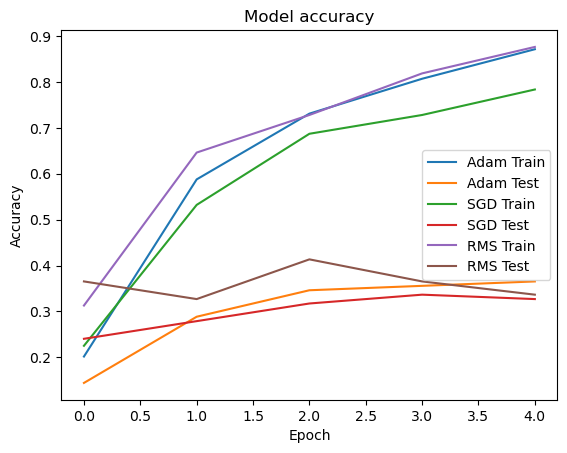

In [62]:
# Plot training & validation accuracy values
plt.plot(accuracies_adam, label = "Adam Train")
plt.plot(val_accuracies_adam, label = "Adam Test")

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [63]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_acc_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_accuracy_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

### Loss values

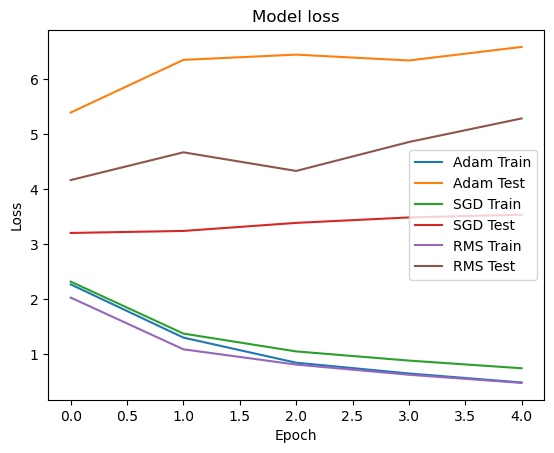

In [64]:
# Plot training & validation loss values
plt.plot(losses_adam, label = "Adam Train")
plt.plot(val_losses_adam, label = "Adam Test")

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [65]:
# plt.savefig(r'/Users/jesus/Desktop/Projecte/XNAPproject-grup07/ouput/model_loss_631_images.png')
plt.savefig('/home/xnmaster/Project/XNAPproject-grup07/ouput/model_loss_3opt_10400im_10art.png')

<Figure size 640x480 with 0 Axes>

# Predict the output 🔮 🎩

In [81]:
PRED_STEPS = len(test_gen) # 100 # default would have been len(test_gen)
PRED_STEPS

281

In [82]:
def retrieve_results(predicted_class_indices, train_gens):
    print(len(predicted_class_indices),"\n",predicted_class_indices)
    print("it has values ranging from ",min(predicted_class_indices),"...to...",max(predicted_class_indices))
    labels = (train_gens[0].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    print("*"*20+"\nclass_indices\n"+"*"*20+"\n",train_gens[0].class_indices,"\n")
    print("*"*20+"\nlabels\n"+"*"*20+"\n",labels,"\n")
    print("*"*20+"\npredictions has", len(predictions),"values that look like","'"+str(predictions[0])+"' which is the first prediction and corresponds to this index of the classes:",train_gens[0].class_indices[predictions[0]])
    # Save the results to a CSV file.
    filenames=test_gen.filenames[:len(predictions)] # because "ValueError: arrays must all be same length"

    real_artists = []
    for f in filenames:
        real = test_df[test_df['new_filename'] == f].artist.to_numpy()[0]
        real_artists.append(real)

    results=pd.DataFrame({"Filename":filenames,
                        "Predictions":predictions,
                        "Real Values":real_artists})
    results.to_csv("results.csv",index=False)

    return results

In [83]:
def testing_new_images(results, training_set_artists):  
    count = 0
    match = 0
    unexpected_count = 0
    unexpected_match = 0
    match_both_expected_unexpected = 0

    for p, r in zip(results['Predictions'], results['Real Values']):
        if r in training_set_artists:
            count += 1
            if p == r:
                match += 1
        else:
            unexpected_count += 1
            if p == r:
                unexpected_match += 1

    print("test accuracy on new images for TRAINED artists")
    acc = match/count
    print(match,"/",count,"=","{:.4f}".format(acc))

    print("test accuracy on new images for UNEXPECTED artists")
    print("unexpected_match", unexpected_match)
    print("unexpected_count", unexpected_count)
    
    if unexpected_count != 0:
        u_acc = unexpected_match/unexpected_count
        print(unexpected_match,"/",unexpected_count,"=","{:.4f}".format(u_acc))

    print("test accuracy on new images")
    total_match = match+unexpected_match
    total_count = count+unexpected_count
    total_acc = (total_match)/(total_count)
    print(total_match,"/",total_count,"=","{:.4f}".format(total_acc))

## Adam

In [84]:
# Need to reset the test_gen before calling predict_generator
# This is important because forgetting to reset the test_generator results in outputs with a weird order.
test_gen.reset()
pred_adam = model_adam.predict(test_gen)

281/281 [==============================] - 229s 767ms/step


In [85]:
print(len(pred_adam),"\n",pred_adam)

10113 
 [[8.04727257e-04 4.04767739e-03 3.89879569e-04 ... 5.35861496e-03
  2.05516844e-05 8.24720628e-05]
 [1.09930761e-05 7.13876216e-04 1.25340803e-03 ... 9.94388130e-04
  3.79198559e-06 2.49061541e-05]
 [1.51381202e-04 8.74841469e-04 3.75820309e-05 ... 6.74502342e-04
  4.13899579e-06 4.49073195e-05]
 ...
 [1.39237553e-01 1.04452565e-01 7.60575582e-04 ... 7.46746222e-03
  5.34233376e-02 2.08907411e-03]
 [1.77956317e-04 6.74847901e-01 6.08954020e-02 ... 8.75055033e-04
  1.24265872e-01 2.19740643e-04]
 [4.03708927e-02 1.24865668e-02 5.25613362e-03 ... 1.17507484e-02
  2.11067483e-01 1.39211980e-03]]


In [86]:
predicted_class_indices_adam=np.argmax(pred_adam,axis=1)

In [87]:
results_adam = retrieve_results(predicted_class_indices_adam, train_gens)

10113 
 [4 4 4 ... 5 1 5]
it has values ranging from  0 ...to... 8
********************
class_indices
********************
 {'Ivan Aivazovsky': 0, 'John Singer Sargent': 1, 'Pierre-Auguste Renoir': 2, 'Marc Chagall': 3, 'Pablo Picasso': 4, 'Zdislav Beksinski': 5, 'Ivan Shishkin': 6, 'Gustave Dore': 7, 'Ilya Repin': 8, 'Giovanni Battista Piranesi': 9} 

********************
labels
********************
 {0: 'Ivan Aivazovsky', 1: 'John Singer Sargent', 2: 'Pierre-Auguste Renoir', 3: 'Marc Chagall', 4: 'Pablo Picasso', 5: 'Zdislav Beksinski', 6: 'Ivan Shishkin', 7: 'Gustave Dore', 8: 'Ilya Repin', 9: 'Giovanni Battista Piranesi'} 

********************
predictions has 10113 values that look like 'Pablo Picasso' which is the first prediction and corresponds to this index of the classes: 4


In [88]:
results_adam.head()

,Filename,Predictions,Real Values
0,32145.jpg,Pablo Picasso,kiri nichol
1,20304.jpg,Pablo Picasso,kiri nichol
2,836.jpg,Pablo Picasso,kiri nichol
3,49823.jpg,Pablo Picasso,Hiroshige
4,84512.jpg,John Singer Sargent,Franz Richard Unterberger


In [89]:
len(training_set_artists)

10

In [92]:
testing_new_images(results_adam, training_set_artists)

test accuracy on new images for TRAINED artists


ZeroDivisionError: division by zero

# Ideas
- Having a the prediction dataset: Filename, Predictions, Real Values. We can construct a composition of the predictions.
- We can now predict artist and another caracteristic (like stryle).

## Mosaics

In [95]:
def calculate_position(current_index, total_images_per_row, image_width, image_height, margin):
    row = current_index // total_images_per_row
    col = current_index % total_images_per_row
    x = col * (image_width + margin)
    y = row * (image_height + margin)
    return (x, y)


### Predictions

In [97]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/compositions/predictions_13000_images/composition_{}.png'.format(predicted_artist))


### Real values

In [104]:
grouped_data = results_adam.groupby('Predictions') # tmb podria ser Real Values

In [ ]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Group by predicted artist
filtered_data = results_adam[results_adam['Real Values'].isin(training_set_artists)]
grouped_data = filtered_data.groupby('Real Values')# tmb podria ser Real Values

# Parameters for composition layout
total_images_per_row = 5
image_width = 200
image_height = 200
margin = 10
max_rows = 21  # Maximum number of rows to display

# Create compositions
for predicted_artist, group in grouped_data:
    # Limit the number of images to max_rows * total_images_per_row
    num_images = min(len(group), max_rows * total_images_per_row)
    
    # Create a new blank image to compose the group of images
    composition_width = total_images_per_row * (image_width + margin) - margin
    num_rows = (num_images + total_images_per_row - 1) // total_images_per_row
    title_height = 30  # Height reserved for the title
    composition_height = num_rows * (image_height + margin) - margin + title_height
    composition = Image.new('RGB', (composition_width, composition_height), color='white')

    # Add the title
    draw = ImageDraw.Draw(composition)
    font = ImageFont.load_default()
    title = "Predicted Artist: {}".format(predicted_artist)
    title_width = draw.textlength(title, font=font)
    draw.text(((composition_width - title_width) // 2, 0), title, fill="black", font=font)

    # Loop through images in the group
    for i, (_, row) in enumerate(group.iterrows()):
        if i >= num_images:
            break
        # Open the image file
        image = Image.open(TEST_DIR + "/" + row['Filename'])
        
        # Resize image if needed
        image = image.resize((image_width, image_height))
        
        # Calculate position to paste this image in the composition
        position = calculate_position(i, total_images_per_row, image_width, image_height, margin)
        position = (position[0], position[1] + title_height)  # Adjust position for title
        
        # Paste the image onto the composition
        composition.paste(image, position)
    
    # Display or save the composition
    # composition.save(r'C:\Users\Mercè\Documents\UAB\XN\Projecte\XNAPproject-grup07\compostions\predictions_631_images\composition_{}.png'.format(predicted_artist))
    composition.save('/home/xnmaster/Project/XNAPproject-grup07/compostions/real_values_13000_images/composition_{}.png'.format(predicted_artist))


Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/anaconda/envs/py38_default/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/service/server_sock.py", line 99, in run
    sreq = self._sock_client.read_server_request()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 274, in read_server_request
    data = self._read_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 248, in _read_packet_bytes
    rec = self._extract_packet_bytes()
  File "/anaconda/envs/py38_default/lib/python3.8/site-packages/wandb/sdk/lib/sock_client.py", line 230, in _extract_packet_bytes
    assert magic == ord("W")
AssertionError
Bad pipe message: %s [b'\xd2\xe9\xa0\xf1I\xb7}r\xe0\x7f\xc0\x83\xc1\xa2A\xa6\xeb\x8e P\xa0f\xb6\xd3\x198\x0e\x8e\xcag\xf0', b'\x19a\x03u\xba\xbe\xfb\x